In [1]:
import sys
sys.path.append('../Data_Feature')
sys.path.append('../Data_processing')
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split, cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef, make_scorer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from bioservices import KEGG
import networkx as nx

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from pyvis.network import Network
from data_processing import KOProcessor 
from scipy.stats import pearsonr, pointbiserialr
import logging
sns.set_palette('crest')

In [2]:
# Global Params
estimator_configs = [
    {
        'name': 'RandomForest',
        'params': {
            'select_k__k': [10, 50, 100, 200, 300, 500, 1000],
            'estimator': [RandomForestClassifier(random_state=42)],
            'estimator__n_estimators': [100, 200, 300],
            'estimator__max_depth': [5, 10, 15, None]
        }
    },
    {
        'name': 'SVC',
        'params': {
            'select_k__k': [10, 50, 100, 200, 300, 500, 1000],
            'estimator': [SVC(random_state=42)],
            'estimator__C': [0.1, 1, 10],
            'estimator__kernel': ['linear', 'rbf'],
            'estimator__gamma': ['scale', 'auto'],
            'estimator__class_weight': [None, 'balanced']
        }
    },
    {
        'name': 'LogisticRegression',
        'params': {
            'select_k__k': [10, 50, 100, 200, 300, 500, 1000],
            'estimator': [LogisticRegression()],
            'estimator__C': [0.01, 0.1, 1, 10, 100]
        }
    },
    {
        'name': 'BernoulliNB',
        'params': {
            'select_k__k': [10, 50, 100, 200, 300, 500, 1000],
            'estimator': [BernoulliNB()],
            'estimator__alpha': [0.01, 0.1, 1.0, 10.0],
            'estimator__binarize': [0.0]
        }
    }
]


param_grid = [
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  
        'estimator': [RandomForestClassifier(random_state=42)],
        'estimator__n_estimators': [100, 200, 300],  
        'estimator__max_depth': [5, 10, 15, None]  
    },

    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  
        'estimator': [SVC(random_state=42)],
        'estimator__C': [0.1, 1, 10],  
        'estimator__kernel': ['linear', 'rbf'], 
        'estimator__gamma': ['scale', 'auto'],
        'estimator__class_weight': [None, 'balanced']
    },
    {
        'select_k__k' : [10, 50, 100, 200, 300, 500, 1000],
        'estimator': [LogisticRegression()],
        'estimator__C': [0.01, 0.1, 1, 10, 100]
    },         
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  
        'estimator': [BernoulliNB()],
        'estimator__alpha': [0.01, 0.1, 1.0, 10.0],  
        'estimator__binarize': [0.0]  # Is automatically applied
    }
]


# For selecting which trait i want to predict



# For selecting which trait to predict
target_trait = "gram"  


Data loaded successfully:
   Unnamed: 0   key      KO
0           0  1000  K00001
1           1  1000  K13954
2           2  1000  K00003
3           3  1000  K00013
4           4  1000  K00014
Data loaded successfully:
   key        ID                      speciesStrain  \
0    1  592010.0   Abiotrophia defectiva ATCC 49176   
1    1     219.0     Abiotrophia defectiva DSM 9849   
2    2  159837.0       Abyssibacter profundi OUC007   
3    3       NaN  Acanthopleuribacter pedis FYK2218   
4    4  258515.0   Acetanaerobacterium elongatum Z7   

                 speciesStrainComp                genus            genusComp  \
0    abiotrophiadefectivaatcc49176          Abiotrophia          abiotrophia   
1      abiotrophiadefectivadsm9849          Abiotrophia          abiotrophia   
2       abyssibacterprofundiouc007         Abyssibacter         abyssibacter   
3  acanthopleuribacterpedisfyk2218  Acanthopleuribacter  acanthopleuribacter   
4   acetanaerobacteriumelongatumz7  Acetanaerobac

c:\Users\eliah\Documents\Master\Eliah-Masters\Pipelines\../Data_processing\data_processing.py:152: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_tokens = pd.unique(all_tokens)


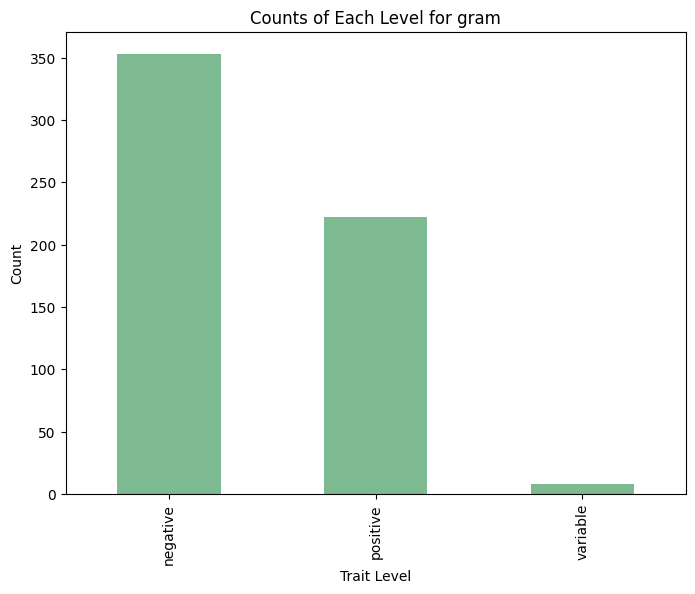

Label encoding mapping:
  0 -> negative
  1 -> positive
  2 -> variable


In [3]:
# Load and preprocess data
terms_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/terms_KO.zip'
terms_csv_path = 'terms_KO.csv'
traits_reduced_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/reducedDataset.zip'
traits_reduced_csv_path = 'reducedDataset.csv'
traits_assembled_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/assembledDataset.zip'
traits_assembled_csv_path = 'assembledDataset.csv'

processor = KOProcessor(
    terms_zip_path, 
    terms_csv_path, 
    traits_reduced_zip_path, 
    traits_reduced_csv_path, 
    traits_assembled_zip_path=traits_assembled_zip_path, 
    traits_assembled_csv_path=traits_assembled_csv_path
)

ko_terms = processor.load_terms()
if ko_terms is None:
        raise FileNotFoundError("KO terms could not be loaded. Please check the file paths.")

reduced_traits_data = processor.load_reduced_traits_data()
if reduced_traits_data is None:
    raise FileNotFoundError("Reduced traits data could not be loaded. Please check the file paths.")

# Debug: Print columns of reduced_traits_data
# print("Columns in reduced_traits_data:", reduced_traits_data.columns.tolist())

# Uses assembled dataset if data not in reduced
traits_assembled = processor.load_assembled_traits_data()
if traits_assembled is not None:
    print("Columns in assembled_traits_data:", traits_assembled.columns.tolist())

#Feature_preprocess = processor.preprocess_features(ko_terms,reduced_traits_data)

# Preprocess KO terms and traits
X_terms = processor.preprocess_terms(ko_terms)
y_traits = processor.preprocess_traits(reduced_traits_data, trait_column=target_trait, use_assembled_if_missing=True)

# Check data validity and extract levels
if y_traits is None:
    raise ValueError(f"Traits data for {target_trait} could not be processed")

# Dynamically get trait levels and validate binary classification
trait_levels = y_traits.unique().tolist()
if len(trait_levels) != 3:
    raise ValueError(f"Target trait '{target_trait}' is not binary. Found levels: {trait_levels}")

#####################################
# Checking occurances of features

trait_counts = y_traits.value_counts()
print(f"Counts of trait levels for {target_trait}:")
for level, count in trait_counts.items():
    print(f"{level}: {count}")

plt.figure(figsize=(8,6))
trait_counts.plot(kind='bar')
plt.title(f"Counts of Each Level for {target_trait}")
plt.xlabel("Trait Level")
plt.ylabel("Count")
plt.show()

######################################


# Check if y_traits was processed correctly
if y_traits is None:
    raise ValueError(f"Traits data for {target_trait} could not be processed. Please check the log for errors.")

# Align features and labels
X_aligned, Y_aligned = processor.align_data(X_terms, y_traits)

# Feature Selection: Variance Threshold
selector = VarianceThreshold(threshold=0.02)
X_aligned = selector.fit_transform(X_aligned)

le = LabelEncoder()
y_enc = le.fit_transform(Y_aligned) 
# now y_enc is an array of 0,1,2 corresponding to ['negative','positive','variable']

print("Label encoding mapping:")
for i, cls in enumerate(le.classes_):
    print(f"  {i} -> {cls}")

def plot_spider(metrics, title, palette_color=None):
    """
    Draw a radar (spider) chart of these five metrics:
      ['F1‑score','Accuracy','Specificity','Sensitivity','Precision', 'MCC']
    `metrics`: dict with those exact keys mapping to floats in [0,1].
    `palette_color`: a single color spec (e.g. seaborn palette color).
    """
    # 1. variable names
    categories = ['F1‑score','Accuracy','Specificity','Sensitivity','Precision', 'MCC']
    N = len(categories)
    # 2. Values and close the loop
    values = [metrics[c] for c in categories]
    values += values[:1]
    # 3. Compute angle of each axis in the plot (in radians)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    # 4. Initialise spider plot
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    # 5. Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, color='grey', size=12)
    # 6. Draw ylabels
    ax.set_rlabel_position(0)
    yticks = [0.25, 0.50, 0.75, 1.00]
    plt.yticks(yticks, [f"{y:.2f}" for y in yticks], color="grey", size=10)
    plt.ylim(0,1)
    # 7. Plot data
    if palette_color is None:
        line_color = 'C0'
        fill_color = 'C0'
    else:
        line_color = palette_color
        fill_color = palette_color
    ax.plot(angles, values, color=line_color, linewidth=2, linestyle='solid', label=title)
    ax.fill(angles, values, color=fill_color, alpha=0.25)
    # 8. Title
    plt.title(title, size=14, y=1.1)
    plt.show()


Label encoding for 'gram':
  0 = negative
  1 = positive
  2 = variable


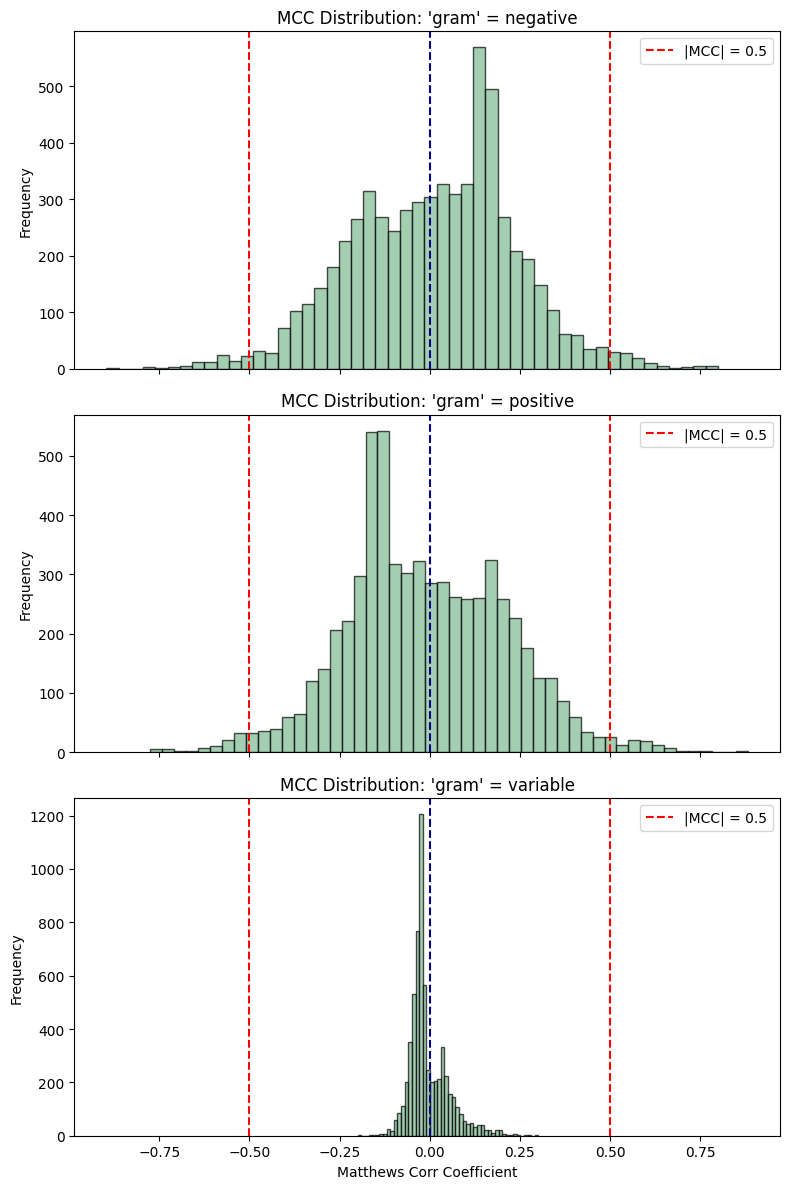

Top positive MCC per label:

Label = 'negative'
     Feature       MCC
2942  K06861  0.799199
4375  K11720  0.795884
2630  K05807  0.780785
415   K00748  0.771042
1497  K02523  0.767787

Label = 'positive'
      Feature       MCC
10123  K09762  0.882792
10133  K09772  0.853953
9447   K07177  0.781204
9322   K07030  0.758152
9088   K06346  0.754236

Label = 'variable'
      Feature       MCC
15943  K07683  0.301795
16188  K08966  0.272410
15360  K06407  0.267509
15951  K07692  0.242111
17956  K18346  0.239475


In [5]:
# 1) Grab original DataFrame (to get column names)
orig_X, _ = processor.align_data(X_terms, y_traits)

# 2) Get the mask of kept features
mask = selector.get_support()

# 3) Selected feature names
feature_names = orig_X.columns[mask]

# 4) Rebuild a DataFrame so we can iterate .columns
X_sel_df = pd.DataFrame(X_aligned, columns=feature_names)

print(f"Label encoding for '{target_trait}':")
le = LabelEncoder()
le.fit(y_traits)
for i, label in enumerate(le.classes_):
    print(f"  {i} = {label}")

records = []
for cls in le.classes_:
    # one‐vs‐rest binary target for this class
    Y_bin = (Y_aligned == cls).astype(int)
    for feat in X_sel_df.columns:
        mcc = matthews_corrcoef(Y_bin, X_sel_df[feat].values)
        records.append({
            'Label': cls,
            'Feature': feat,
            'MCC': mcc
        })

mcc_df = pd.DataFrame.from_records(records)

# 6) Optionally filter for “strong” MCCs
sig_mcc_df = mcc_df[ mcc_df['MCC'].abs() > 0.5 ]

# 7) Now plot a separate histogram for each label
n_labels = len(le.classes_)
fig, axes = plt.subplots(n_labels, 1, figsize=(8, 4*n_labels), sharex=True)

for ax, cls in zip(axes, le.classes_):
    data = mcc_df.loc[mcc_df['Label'] == cls, 'MCC']
    ax.hist(data, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='darkblue', linestyle='--')
    ax.axvline( 0.5, color='red',    linestyle='--', label='|MCC| = 0.5')
    ax.axvline(-0.5, color='red',    linestyle='--')
    ax.set_title( f"MCC Distribution: '{target_trait}' = {cls}" )
    ax.set_ylabel('Frequency')
    ax.legend()

axes[-1].set_xlabel('Matthews Corr Coefficient')
plt.tight_layout()
plt.show()

# 8) Preview your results
print("Top positive MCC per label:")
for cls in le.classes_:
    top = mcc_df[mcc_df['Label']==cls].nlargest(5, 'MCC')
    print(f"\nLabel = {cls!r}")
    print(top[['Feature','MCC']])

 p-value tells you how likely it is that the observed correlation is due to chance:

p < 0.05 → Statistically significant: the correlation is likely real.

p ≥ 0.05 → Not significant: we can’t confidently say the correlation is meaningful.
histogram  shows  how all features are spread across the correlation spectrum:

If the plot is centered around 0, most features have no real correlation.

If it’s skewed to the right (positive r) → more features associate with Gram-positive or variable.

If it’s skewed left (negative r) → more features associate with Gram-negative.


Correlation (r) | Interpretation
r ≈ -1 | Feature is more present in Gram-negative microbes
r ≈ 0 | Feature doesn't strongly distinguish Gram types
r ≈ +1 | Feature is more present in Gram-variable or Gram-positive microbes

But BE CAREFUL: Pearson doesn’t understand that 0, 1, 2 are categories. If variable is rare, it might skew things.

 try point-biserial correlation (for binary) or ANOVA/Kruskal-Wallis (for multiclass)????
 

In [ ]:
# STRATIFIED K-FOLD PIPELINE with multiple confusion matrixes
#############################################
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Crest palette
sns.set_palette('crest')
cmap = 'crest'

#############################################
# Helper Function: Binary Table Creation
#############################################

def create_binary_trait_table(trait_series, trait_name, trait_levels, delimiter=","):
    binary_df = pd.DataFrame(index=trait_series.index)
    for level in trait_levels:
        col = f"{trait_name}_{level}"
        binary_df[col] = trait_series.apply(lambda x: 1 if pd.notnull(x) and level in str(x).split(delimiter) else 0)
    return binary_df

#############################################
# Post-Prediction Visualization Functions
#############################################

def plot_confusion_matrix(cm, title, class_labels):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

def plot_side_by_side_comparison(actual_binary, predicted_binary, title):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(actual_binary, annot=True, fmt="d", cmap=cmap, cbar=False, ax=axes[0])
    axes[0].set_title("Actual Binary Table\n" + title)
    sns.heatmap(predicted_binary, annot=True, fmt="d", cmap=cmap, cbar=False, ax=axes[1])
    axes[1].set_title("Predicted Binary Table\n" + title)
    plt.show()

def plot_distribution_comparison(actual_binary, predicted_binary, title):
    actual_counts = {col: actual_binary[col].sum() for col in actual_binary.columns}
    predicted_counts = {col: predicted_binary[col].sum() for col in predicted_binary.columns}
    dist_df = pd.DataFrame({'Actual Yes': pd.Series(actual_counts),
                             'Predicted Yes': pd.Series(predicted_counts)})
    dist_df.plot(kind='bar', figsize=(10, 6), colormap='crest')
    plt.title("Distribution Comparison\n" + title)
    plt.xlabel("Trait Levels")
    plt.ylabel("Count")
    plt.show()


#############################################
# Integrated Pipeline with Radar Overlay
#############################################

def train_and_evaluate_with_test_set(X_aligned, Y_aligned, target_trait, trait_levels,
                                     test_size=0.2, random_state=42):
    logging.info(f"Processing trait: {target_trait}")
    if not isinstance(Y_aligned, pd.Series):
        Y_aligned = pd.Series(Y_aligned, index=X_aligned.index)

    # split
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_aligned, Y_aligned,
        test_size=test_size, random_state=random_state,
        stratify=Y_aligned)
    logging.info(f"Data split: {X_train.shape[0]} train, {X_test.shape[0]} test")

    actual_binary_test = create_binary_trait_table(Y_test, target_trait, trait_levels)

    best_models = {}
    metrics_by_model = {}
    palette = sns.color_palette('crest', n_colors=len(estimator_configs))

    for idx, config in enumerate(estimator_configs):
        name = config['name']
        color = palette[idx]
        logging.info(f"Grid search for {name}")
        pipeline = Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', config['params']['estimator'][0])
        ])
        gs = GridSearchCV(pipeline, config['params'],
                          cv=StratifiedKFold(5, shuffle=True, random_state=random_state),
                          n_jobs=-1, verbose=1)
        gs.fit(X_train, Y_train)

        logging.info(f"Best params for {name}: {gs.best_params_}")
        logging.info(f"Best CV score for {name}: {gs.best_score_:.3f}")

        model = gs.best_estimator_
        best_models[name] = model

        # test evaluation
        y_pred = model.predict(X_test)
        cm = confusion_matrix(Y_test, y_pred)
        mcc = matthews_corrcoef(Y_test, y_pred)
        f1   = f1_score(Y_test, y_pred, average='macro')
        acc  = accuracy_score(Y_test, y_pred)
        prec = precision_score(Y_test, y_pred, average='macro')
        sens = recall_score(Y_test, y_pred, average='macro')
        tp = np.diag(cm)
        fp = cm.sum(axis=0) - tp
        fn = cm.sum(axis=1) - tp
        tn = cm.sum() - (tp + fp + fn)
        spec = np.mean(tn/(tn+fp))

        metrics = {'F1-score':f1, 'Accuracy':acc, 'Specificity':spec,
                   'Sensitivity':sens, 'Precision':prec, 'MCC':mcc}
        metrics_by_model[name] = metrics
        logging.info(f"Metrics for {name}: {metrics}")

        # existing per-model plots
        plot_confusion_matrix(cm, f"{target_trait} - {name} (Overall)", sorted(set(Y_test)|set(y_pred)))
        for level in trait_levels:
            y_true_b = [1 if y == level else 0 for y in Y_test]
            y_pred_b = [1 if y == level else 0 for y in y_pred]
            cm_b = confusion_matrix(y_true_b, y_pred_b)
            plot_confusion_matrix(cm_b, f"{target_trait} - {name} (Level='{level}')",
                                  [f"Not {level}", level])
        pred_bin = create_binary_trait_table(pd.Series(y_pred, index=Y_test.index),
                                             target_trait, trait_levels)
        plot_side_by_side_comparison(actual_binary_test, pred_bin,
                                     f"{target_trait} (Test Set) - {name}")
        plot_distribution_comparison(actual_binary_test, pred_bin,
                                     f"{target_trait} (Test Set) - {name}")

    # --- single overlay spider chart for all models ---
    categories = ['F1-score','Accuracy','Specificity','Sensitivity','Precision','MCC']
    N = len(categories)
    angles = [n/float(N)*2*np.pi for n in range(N)] + [0]

    fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))
    plt.xticks(angles[:-1], categories, color='grey', size=12)
    ax.set_rlabel_position(0)
    yticks = [0.25,0.5,0.75,1.0]
    plt.yticks(yticks, [f"{y:.2f}" for y in yticks], color='grey', size=10)
    plt.ylim(0,1)

    for idx, (name, met) in enumerate(metrics_by_model.items()):
        values = [met[c] for c in categories] + [met[categories[0]]]
        color = palette[idx]
        ax.plot(angles, values, label=name, color=color, linewidth=2)
        ax.fill(angles, values, color=color, alpha=0.1)

    plt.title(f"Comparison of metrics by estimator for {target_trait}", size=16, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3,1.1))
    plt.show()

    return best_models, metrics_by_model

# Example usage:
best_models, all_metrics = train_and_evaluate_with_test_set(X_aligned, Y_aligned, target_trait, trait_levels)

In [ ]:
# Plot analysis
########################################################

'''# --------------------------
# Jaccard Index Stability Analysis-------------> Shows wich features are periodically selected for
# --------------------------
n_folds = 5
selected_features = []
skf = StratifiedKFold(n_splits=n_folds)

# Track selected features across folds
for train_idx, _ in skf.split(X_aligned, Y_aligned):
    selector = SelectKBest(f_classif, k=100)
    selector.fit(X_aligned[train_idx], Y_aligned[train_idx])
    # Convert feature_names to a numpy array for boolean indexing
    selected_features.append(set(np.array(feature_names)[selector.get_support()]))

# Compute Jaccard matrix
jaccard_matrix = np.zeros((n_folds, n_folds))
for i in range(n_folds):
    for j in range(n_folds):
        intersection = len(selected_features[i] & selected_features[j])
        union = len(selected_features[i] | selected_features[j])
        jaccard_matrix[i, j] = intersection / union

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_matrix, annot=True, cmap="YlGnBu", 
            xticklabels=range(1, n_folds+1), 
            yticklabels=range(1, n_folds+1))
plt.title("Feature Stability Across CV Folds (Jaccard Index)")
plt.xlabel("Fold")
plt.ylabel("Fold")
plt.show()
'''

'''# --------------------------
# Ablation Study (Skip models without feature importance)
# --------------------------
if grid_search is not None:
    best_model = grid_search.best_estimator_
    estimator_name = best_model.named_steps['estimator'].__class__.__name__
    
    # Skip models without feature importance/coefficients
    if not (hasattr(best_model.named_steps['estimator'], 'feature_importances_') or 
            hasattr(best_model.named_steps['estimator'], 'coef_')):
        print(f"Skipping ablation for {estimator_name} (no feature importance available)")
    else:
        # Get feature importances
        if hasattr(best_model.named_steps['estimator'], 'feature_importances_'):
            importances = best_model.named_steps['estimator'].feature_importances_
        else:
            importances = np.abs(best_model.named_steps['estimator'].coef_[0])
        
        # Remove top 10% features
        n_features_to_remove = int(0.1 * len(importances))
        top_features = np.argsort(importances)[-n_features_to_remove:]
        
        # Create ablated dataset
        X_ablated = np.delete(X_aligned, top_features, axis=1)
        
        # Evaluate ablated performance
        X_train_ablate, X_test_ablate, Y_train_ablate, Y_test_ablate = train_test_split(
            X_ablated, Y_aligned, test_size=0.3, stratify=Y_aligned, random_state=42
        )
        
        best_model.fit(X_train_ablate, Y_train_ablate)
        ablated_score = f1_score(Y_test_ablate, best_model.predict(X_test_ablate), average='macro')
        
        print(f"Original F1: {grid_search.best_score_:.3f}")  # Use grid_search's best_score_
        print(f"Ablated F1: {ablated_score:.3f}")
        print(f"Features removed: {len(top_features)}/{X_aligned.shape[1]}")
else:
    print("Error: grid_search not found.")'''



'''# --------------------------
# SHAP Value Analysis
# --------------------------

# Create explainer
explainer = shap.Explainer(grid_search.best_estimator_.named_steps['estimator'])
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=np.unique(Y_aligned))'''

In [ ]:
# STRATIFIED K-FOLD PIPELINE with multiple confusion matrices for best performing method
#############################################
# Configure logging to include timestamps and log levels
#############################################
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
#crest colormap for heatmaps
sns.set_palette('crest')        # set default line and bar colors to crest
cmap = sns.color_palette("crest", as_cmap=True)  # create a colormap object

#############################################
# Helper Function: Binary Table Creation
#############################################
def create_binary_trait_table(trait_series, trait_name, trait_levels=None, delimiter=","):
    """Dynamically creates binary columns based on provided or observed trait levels"""
    if trait_levels is None:
        trait_levels = trait_series.unique().tolist()
    binary_df = pd.DataFrame(index=trait_series.index)
    
    for level in trait_levels:
        col_name = f"{trait_name}_{str(level).replace(' ', '_')}"
        binary_df[col_name] = trait_series.apply(
            lambda x: 1 if str(level) in str(x).split(delimiter) else 0
        )
    return binary_df

#############################################
# Post-Prediction Visualization Functions
#############################################
def plot_confusion_matrix(cm, title, class_labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False,  # was 'Blues'
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()


def plot_side_by_side_comparison(actual_binary, predicted_binary, title):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(actual_binary, annot=True, fmt="d", cmap='crest', cbar=False, ax=axes[0])  # was 'YlGnBu'
    axes[0].set_title("Actual Binary Table\n" + title)
    sns.heatmap(predicted_binary, annot=True, fmt="d", cmap='crest', cbar=False, ax=axes[1])  # was 'YlGnBu'
    axes[1].set_title("Predicted Binary Table\n" + title)
    plt.show()


def plot_distribution_comparison(actual_binary, predicted_binary, title):
    actual_counts = {col: actual_binary[col].sum() for col in actual_binary.columns}
    predicted_counts = {col: predicted_binary[col].sum() for col in predicted_binary.columns}
    dist_df = pd.DataFrame({
        'Actual Yes': pd.Series(actual_counts),
        'Predicted Yes': pd.Series(predicted_counts)
    })
    dist_df.plot(kind='bar', figsize=(10, 6), colormap='crest')  # added colormap='crest'
    plt.title("Distribution Comparison\n" + title)
    plt.xlabel("Trait Levels")
    plt.ylabel("Count")
    plt.show()


#############################################
# Integrated Pipeline with Independent Test Set Using StratifiedKFold
#############################################
def train_and_evaluate_with_test_set(X_aligned, Y_aligned, target_trait, trait_levels, test_size=0.2, random_state=42):
    results = {}
    logging.info(f"Processing trait: {target_trait}")
    
    # Ensure Y_aligned is a pandas Series
    if not isinstance(Y_aligned, pd.Series):
        Y_aligned = pd.Series(Y_aligned, index=X_aligned.index)
    
    # Split the data into training and test sets (using stratification)
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_aligned, Y_aligned, test_size=test_size, random_state=random_state, stratify=Y_aligned
    )
    logging.info(f"Data split: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples.")
    
    # Build Binary Table for Test Set (for later comparison)
    actual_binary_test = create_binary_trait_table(Y_test, target_trait, trait_levels=trait_levels)
    
    # Main ML Pipeline with Grid Search on Training Set
    pipeline = Pipeline([
        ('select_k', SelectKBest(f_classif)),
        ('estimator', RandomForestClassifier())
    ])
    
    # Use StratifiedKFold CV (instead of Leave-One-Out) on the training set for grid search
    skf_train = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    logging.info("Starting grid search with StratifiedKFold CV on the training set.")
    grid_search = GridSearchCV(pipeline, param_grid, cv=skf_train, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, Y_train)
    
    logging.info(f"Best parameters for {target_trait}: {grid_search.best_params_}")
    logging.info(f"Best CV score for {target_trait}: {grid_search.best_score_:.3f}")
    
    best_model = grid_search.best_estimator_
    
    # Evaluate the final model on the independent test set
    Y_pred_test = best_model.predict(X_test)
    mcc_test = matthews_corrcoef(Y_test, Y_pred_test)
    f1_test = f1_score(Y_test, Y_pred_test, average='macro')
    logging.info(f"Test Set Evaluation - MCC: {mcc_test:.3f}, F1 Score: {f1_test:.3f}")

    # Calculate metrics for spider plot
    mcc_test = matthews_corrcoef(Y_test, Y_pred_test)
    f1_test = f1_score(Y_test, Y_pred_test, average='macro')
    accuracy = accuracy_score(Y_test, Y_pred_test)
    precision = precision_score(Y_test, Y_pred_test, average='macro')
    sensitivity = recall_score(Y_test, Y_pred_test, average='macro')  # Sensitivity = Recall
    
    # Calculate specificity using confusion matrix
    cm = confusion_matrix(Y_test, Y_pred_test)
    specificity_scores = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
        fp = cm[:,i].sum() - cm[i,i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_scores.append(specificity)
    specificity = np.mean(specificity_scores)
    
    # Organize metrics
    metrics = {
        'F1‑score': f1_test,
        'Accuracy': accuracy,
        'Specificity': specificity,
        'Sensitivity': sensitivity,
        'Precision': precision,
        'MCC': mcc_test
    }
    
    # Generate spider plot
    plot_spider(metrics, f"Model Performance: {target_trait}", palette_color=cmap(0.75))
    
    # Overall confusion matrix
    cm_test = confusion_matrix(Y_test, Y_pred_test)
    class_labels = sorted(list(set(Y_test) | set(Y_pred_test)))  # Get all unique class labels
    plot_confusion_matrix(cm_test, f"{target_trait} Classifier (Test Set)", class_labels)
    
    # One-vs-rest confusion matrices for each trait level
    for level in trait_levels:
        # Create binary labels: 1 if the trait equals the current level, else 0
        y_true_binary = [1 if y == level else 0 for y in Y_test]
        y_pred_binary = [1 if y == level else 0 for y in Y_pred_test]
        cm_binary = confusion_matrix(y_true_binary, y_pred_binary)
        # Define binary class labels for clarity
        binary_labels = [f"Not {level}", level]
        plot_confusion_matrix(cm_binary, f"{target_trait} - One-vs-Rest for '{level}'", binary_labels)

    
    
    predicted_series_test = pd.Series(Y_pred_test, index=Y_test.index)
    predicted_binary_test = create_binary_trait_table(predicted_series_test, target_trait, trait_levels)
    
    plot_side_by_side_comparison(actual_binary_test, predicted_binary_test, f"{target_trait} (Test Set)")
    plot_distribution_comparison(actual_binary_test, predicted_binary_test, f"{target_trait} (Test Set)")
    
    return results

# Run the pipeline
results = train_and_evaluate_with_test_set(X_aligned, Y_aligned, target_trait, trait_levels)


In [ ]:
'''# LEAVE ONE OUT PIPELINE
#############################################

# Configure logging to include timestamps and log levels
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

#############################################
# Helper Function: Binary Table Creation
#############################################

def create_binary_trait_table(trait_series, trait_name, trait_levels, delimiter=","):
    """
    Converts a trait Series into a binary DataFrame with one column per trait level.
    For each sample, each column is assigned 1 (Yes) if that level is present and 0 (No) otherwise.
    Works even if the trait contains multiple levels in a single string.
    """
    binary_df = pd.DataFrame(index=trait_series.index)
    for level in trait_levels:
        col_name = f"{trait_name}_{level}"
        def check_level(x):
            if pd.isnull(x):
                return 0
            if isinstance(x, list):
                return 1 if level in x else 0
            parts = [p.strip() for p in str(x).split(delimiter)]
            return 1 if level in parts else 0
        binary_df[col_name] = trait_series.apply(check_level)
    return binary_df

#############################################
# Post-Prediction Visualization Functions
#############################################

def plot_confusion_matrix(cm, title, class_labels):
    """Plots a heatmap of the confusion matrix with correct labels."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()


def plot_side_by_side_comparison(actual_binary, predicted_binary, title):
    """Displays a side-by-side heatmap comparison of actual vs. predicted binary trait tables."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(actual_binary, annot=True, fmt="d", cmap='YlGnBu', cbar=False, ax=axes[0])
    axes[0].set_title("Actual Binary Table\n" + title)
    sns.heatmap(predicted_binary, annot=True, fmt="d", cmap='YlGnBu', cbar=False, ax=axes[1])
    axes[1].set_title("Predicted Binary Table\n" + title)
    plt.show()

def plot_distribution_comparison(actual_binary, predicted_binary, title):
    """Creates a grouped bar chart comparing the distribution (Yes counts) of actual vs. predicted values."""
    actual_counts = {col: actual_binary[col].sum() for col in actual_binary.columns}
    predicted_counts = {col: predicted_binary[col].sum() for col in predicted_binary.columns}
    dist_df = pd.DataFrame({
        'Actual Yes': pd.Series(actual_counts),
        'Predicted Yes': pd.Series(predicted_counts)
    })
    dist_df.plot(kind='bar', figsize=(10, 6))
    plt.title("Distribution Comparison\n" + title)
    plt.xlabel("Trait Levels")
    plt.ylabel("Count")
    plt.show()



#############################################
# Integrated Pipeline with Independent Test Set Using LOO
#############################################

def train_and_evaluate_with_test_set(X_aligned, Y_aligned, target_trait, trait_levels, test_size=0.2, random_state=42):
    results = {}
    logging.info(f"Processing trait: {target_trait}")
    
    # Ensure Y_aligned is a pandas Series
    if not isinstance(Y_aligned, pd.Series):
        Y_aligned = pd.Series(Y_aligned, index=X_aligned.index)
    
    # Split the data into training and test sets (using stratification)
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_aligned, Y_aligned, test_size=test_size, random_state=random_state, stratify=Y_aligned
    )
    logging.info(f"Data split: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples.")
    
    # --- Build Binary Table for Test Set (for later comparison) ---
    actual_binary_test = create_binary_trait_table(Y_test, target_trait, trait_levels)
    
    # --- Main ML Pipeline with Grid Search on Training Set ---
    pipeline = Pipeline([
        ('select_k', SelectKBest(f_classif)),
        ('estimator', RandomForestClassifier(random_state=random_state))
    ])
    
    # Use Leave-One-Out CV on the training set for grid search
    loo_train = LeaveOneOut()
    logging.info("Starting grid search with Leave-One-Out CV on the training set.")
    grid_search = GridSearchCV(pipeline, param_grid, cv=loo_train, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, Y_train)
    
    logging.info(f"Best parameters for {target_trait}: {grid_search.best_params_}")
    logging.info(f"Best CV score for {target_trait}: {grid_search.best_score_:.3f}")
    
    best_model = grid_search.best_estimator_
    
    # --- Evaluate the Final Model on the Independent Test Set ---
    Y_pred_test = best_model.predict(X_test)
    mcc_test = matthews_corrcoef(Y_test, Y_pred_test)
    f1_test = f1_score(Y_test, Y_pred_test, average='macro')
    logging.info(f"Test Set Evaluation - MCC: {mcc_test:.3f}, F1 Score: {f1_test:.3f}")
    
    # Plot test set evaluation results
    cm_test = confusion_matrix(Y_test, Y_pred_test)
    class_labels = sorted(list(set(Y_test) | set(Y_pred_test)))  # Get all unique class labels
    plot_confusion_matrix(cm_test, f"{target_trait} Classifier (Test Set)", class_labels)
    
    # Create binary table for predicted test labels and compare with actual
    predicted_series_test = pd.Series(Y_pred_test, index=Y_test.index)
    predicted_binary_test = create_binary_trait_table(predicted_series_test, target_trait, trait_levels)
    
    plot_side_by_side_comparison(actual_binary_test, predicted_binary_test, f"{target_trait} (Test Set)")
    plot_distribution_comparison(actual_binary_test, predicted_binary_test, f"{target_trait} (Test Set)")
    
    return results

#######################
# Trait selection
#######################

results = train_and_evaluate_with_test_set(X_aligned, Y_aligned, target_trait, trait_levels)'''

Processing estimator: RandomForest
  Testing with k = 1
  Testing with k = 201
  Testing with k = 401
  Testing with k = 601
  Testing with k = 801
Processing estimator: SVC
  Testing with k = 1
  Testing with k = 201
  Testing with k = 401
  Testing with k = 601
  Testing with k = 801
Processing estimator: LogisticRegression
  Testing with k = 1
  Testing with k = 201
  Testing with k = 401
  Testing with k = 601
  Testing with k = 801
Processing estimator: BernoulliNB
  Testing with k = 1
  Testing with k = 201
  Testing with k = 401
  Testing with k = 601
  Testing with k = 801


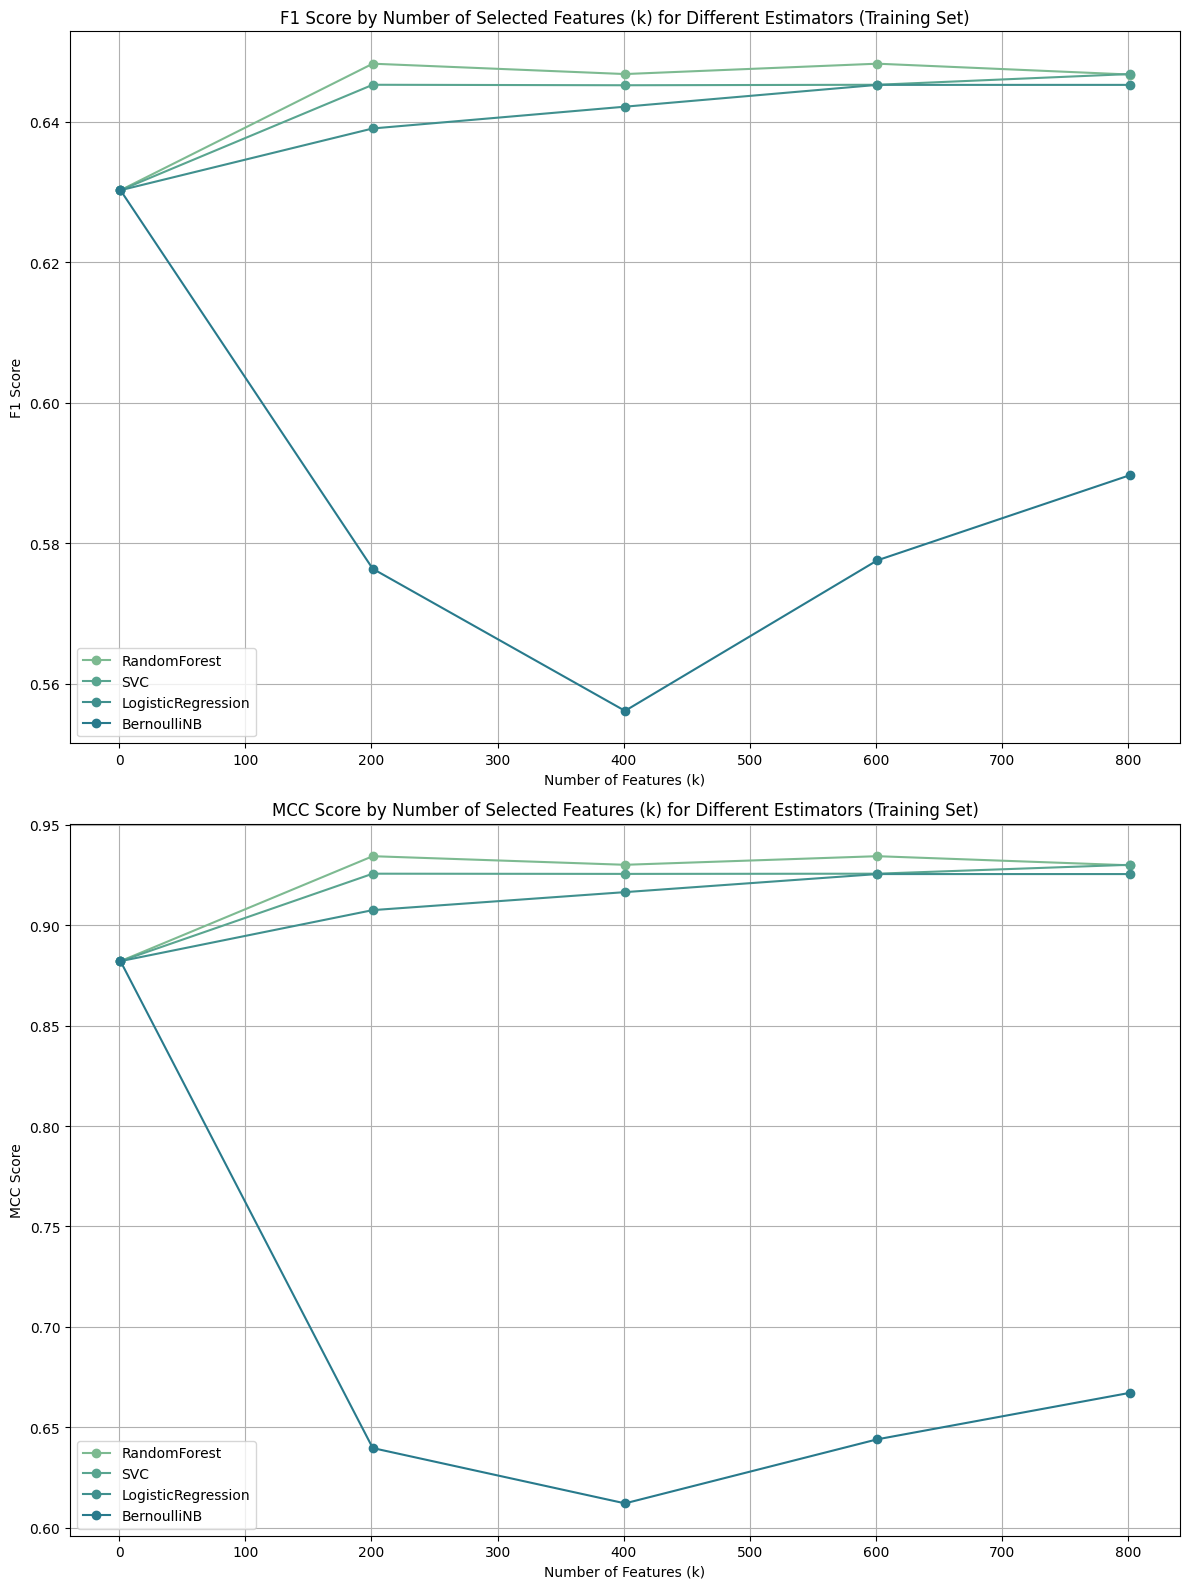

In [ ]:
# --------------------------
# MCC vs. F1 Plot (Integrated with Cell 4 Pipeline)
# --------------------------
# Use the same train/test split as Cell 4
X_train, X_test, Y_train, Y_test = train_test_split(
    X_aligned, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# Prepare results dictionary
results = {config['name']: {'f1': [], 'mcc': []} for config in estimator_configs}

# Define k values to test
k_values = range(1, min(1000, X_train.shape[1]), 50)  # Prevent k > features

# StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5)

for config in estimator_configs:
    name = config['name']
    estimator = config['params']['estimator'][0]
    print(f"Processing estimator: {name}")
    
    for k in k_values:
        print(f"  Testing with k = {k}")
        pipeline = Pipeline([
            ('select_k', SelectKBest(f_classif, k=k)),
            ('estimator', estimator)
        ])
        
        # Modified F1 calculation with zero_division
        f1_scores = cross_val_score(
            pipeline, X_train, Y_train, cv=cv,
            scoring=make_scorer(f1_score, average='macro', zero_division=0),  # Key fix here
            n_jobs=-1
        )
        results[name]['f1'].append(f1_scores.mean())
        
        # Existing MCC calculation remains unchanged
        mcc_scores = cross_val_score(
            pipeline, X_train, Y_train, cv=cv,
            scoring=make_scorer(matthews_corrcoef), 
            n_jobs=-1
        )
        results[name]['mcc'].append(mcc_scores.mean())

gfig, ax = plt.subplots(2, 1, figsize=(12, 16))

for name, scores in results.items():
    k_values_list = list(k_values)
    # F1 Score Plot
    finite_f1_scores = [score for score in scores['f1'] if np.isfinite(score)]
    finite_k_values_f1 = [k for k, score in zip(k_values_list, scores['f1']) if np.isfinite(score)]
    ax[0].plot(finite_k_values_f1, finite_f1_scores, marker='o', linestyle='-', label=name)
    # MCC Score Plot
    finite_mcc_scores = [score for score in scores['mcc'] if np.isfinite(score)]
    finite_k_values_mcc = [k for k, score in zip(k_values_list, scores['mcc']) if np.isfinite(score)]
    ax[1].plot(finite_k_values_mcc, finite_mcc_scores, marker='o', linestyle='-', label=name)

# Customize the F1 plot
ax[0].set_title('F1 Score by Number of Selected Features (k) for Different Estimators (Training Set)')
ax[0].set_xlabel('Number of Features (k)')
ax[0].set_ylabel('F1 Score')
ax[0].legend()
ax[0].grid(True)

# Customize the MCC plot
ax[1].set_title('MCC Score by Number of Selected Features (k) for Different Estimators (Training Set)')
ax[1].set_xlabel('Number of Features (k)')
ax[1].set_ylabel('MCC Score')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# after align_data, make sure Y_aligned is a Series:
# if align_data gave you a DataFrame, do:
y = Y_aligned[target_trait]      # now y is 1-D

X_train, X_test, y_train, y_test = train_test_split(
    X_aligned,
    y_enc,                       # ← 1-D
    stratify=y_enc,              # ← 1-D
    test_size=0.2,
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
k_values = list(range(5, min(500, X_train.shape[1]), 5))

results = {'RF': {'f1': [], 'mcc': []}}

for k in k_values:
    pipe = Pipeline([
        ('select_k', SelectKBest(f_classif, k=k)),
        ('clf', RandomForestClassifier(random_state=42))
    ])
    # now y_train is 1-D, so f1_score will compute valid numbers
    f1_scores  = cross_val_score(
        pipe, X_train, y_train, cv=cv,
        scoring=make_scorer(f1_score, average='macro', zero_division=0),
        n_jobs=-1
    )
    mcc_scores = cross_val_score(
        pipe, X_train, y_train, cv=cv,
        scoring=make_scorer(matthews_corrcoef),
        n_jobs=-1
    )
    print(f"k={k} → F1 folds:", np.round(f1_scores, 3))
    results['RF']['f1'].append(f1_scores.mean())
    results['RF']['mcc'].append(mcc_scores.mean())

# plotting (now you’ll see a real curve)
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,12))
ax1.plot(k_values, results['RF']['f1'],  marker='o', label='RF')
ax2.plot(k_values, results['RF']['mcc'], marker='o', label='RF')
ax1.set(title="Macro-F1 vs k", xlabel="k (features)", ylabel="F1 macro")
ax2.set(title="MCC vs k",       xlabel="k (features)", ylabel="MCC")
for ax in (ax1, ax2):
    ax.legend(); ax.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
''' Pearson R for correlation coefficient between feature importance scores (From both models)'''

lr_model = LogisticRegression(solver='lbfgs', penalty="l2")
rf_model = RandomForestClassifier(n_estimators=500, max_depth=100, min_samples_split=5, random_state=42)


lr_model.fit(X_aligned, Y_aligned)
rf_model.fit(X_aligned, Y_aligned)


logistic_importance = np.abs(lr_model.coef_[0])
rf_feature_importance = rf_model.feature_importances_

# Pearson correlation
pearson_corr, p_value = pearsonr(logistic_importance, rf_feature_importance)

print(f"Pearson Correlation Coefficient: {pearson_corr:.3f}")
#print(f"P-Value: {p_value:.3f}")

# Bootstrap Pearson correlation coefficients
n_bootstraps = 10000
corr_coefficients = []

for _ in range(n_bootstraps):
    # Sample indices with replacement
    indices = resample(np.arange(len(logistic_importance)))
    
    # Calculate Pearson correlation for the sample
    r, _ = pearsonr(logistic_importance[indices], rf_feature_importance[indices])
    corr_coefficients.append(r)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=30, color='red', edgecolor='black')
plt.title('Bootstrap Dist. of Pearson Correlation Coefficients')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# KEGG Pathway Mapping
def map_ko_to_pathways(ko_terms):
    kegg = KEGG()
    pathways = {}
    for ko in ko_terms:
        try:
            gene_links = kegg.link("pathway", ko)
            if gene_links:
                for entry in gene_links.strip().split("\n"):
                    split_entry = entry.split("\t")
                    if len(split_entry) >= 2:
                        ko_id, pathway_id = split_entry[0], split_entry[1]
                        if pathway_id not in pathways:
                            pathways[pathway_id] = set()
                        pathways[pathway_id].add(ko)
        except Exception as e:
            print(f"Error processing {ko}: {e}")
    return pathways

selected_important_features = X_terms.columns[selector.get_support()]
pathways = map_ko_to_pathways(selected_important_features)

# Creating the adjacency matrix with translated KO terms, including original KO term
translated_kos = {ko: f"Translated_{ko}" for ko in selected_important_features}  # Placeholder for actual translation function
pathway_matrix = pd.DataFrame(
    index=[f"{translated_kos[ko]} ({ko})" for ko in selected_important_features],
    columns=pathways.keys(),
    data=0
)
for pathway, kos in pathways.items():
    for ko in kos:
        if ko in selected_important_features:
            pathway_matrix.loc[f"{translated_kos[ko]} ({ko})", pathway] = 1

# Fetch and rename pathway names for readability
kegg = KEGG()
for column in pathway_matrix.columns:
    pathway_info = kegg.get(column)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else column
    pathway_matrix.rename(columns={column: pathway_name}, inplace=True)

print("Pathway matrix after renaming:\n", pathway_matrix)

# Heatmap visualization
sns.heatmap(pathway_matrix, annot=True, cmap="Greys", cbar=False)
plt.title(f'Adjacency Matrix of KO Terms and Pathways ({target_trait})')
plt.xlabel('Pathways')
plt.ylabel('KO Terms')
plt.show()

# Network Visualization
G = nx.Graph()

# Define a list of general pathways to exclude
excluded_pathways = ["metabolic pathways"]  # You can add more general terms here

# Add nodes and edges with renamed pathway names
for ko in selected_important_features:
    translated_label = f"{translated_kos[ko]} ({ko})"
    G.add_node(ko, title=translated_label, label=translated_label, color='red', size=20)

for pathway_id, kos in pathways.items():
    pathway_info = kegg.get(pathway_id)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else pathway_id
    if pathway_name.lower() not in excluded_pathways:
        G.add_node(pathway_name, title=pathway_name, label=pathway_name, color='blue', size=30)
        for ko in kos:
            G.add_edge(ko, pathway_name)

# Pyvis network visualization
nt = Network("800px", "1200px", notebook=True, heading=f'Interactive Network of KO Terms and Pathways ({target_trait})', bgcolor="#ffffff", font_color="black", cdn_resources='remote')
nt.from_nx(G)
nt.toggle_physics(True)
nt.show_buttons(filter_=['physics'])
nt.save_graph(f"ko_network_{target_trait}.html")
